In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
import albumentations as A

In [2]:
class CustomOxFordPet(Dataset):
    def __init__(self, root:str = "/media/mountHDD2/oxfordpet", split = 'trainval'):
        self.root = root
        self._split = split
        self.__mode = "train" if self._split == 'trainval' else 'test'

        self.resize = A.Compose(
            [
                A.Resize(256, 256),
            ]
        )

        self.aug_transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.5, border_mode = cv2.BORDER_CONSTANT),
            ]
        )

        self.norm = A.Compose(
            [
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        self._images_folder = self.root + "/images"
        self._anns_folder = self.root + "/annotations"
        self._segs_folder = self._anns_folder + "/trimaps"

        image_ids = []
        self._labels = []
        with open(self._anns_folder + f"/{self._split}.txt") as file:
            for line in file:
                image_id, label, *_ = line.strip().split()
                image_ids.append(image_id)
                self._labels.append(int(label) - 1)

        self.classes = [
            " ".join(part.title() for part in raw_cls.split("_"))
            for raw_cls, _ in sorted(
                {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, self._labels)},
                key=lambda image_id_and_label: image_id_and_label[1],
            )
        ]
        self.class_to_idx = dict(zip(self.classes, range(len(self.classes))))

        self._images = [self._images_folder + f"/{image_id}.jpg" for image_id in image_ids]
        self._segs = [self._segs_folder + f"/{image_id}.png" for image_id in image_ids]

    @staticmethod
    def process_mask(x):
        uniques = torch.unique(x, sorted = True)
        if uniques.shape[0] > 3:
            x[x == 0] = uniques[2]
            uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        
        x = x.to(dtype=torch.long)
        onehot = F.one_hot(x.squeeze(1), 3).permute(0, 3, 1, 2)[0].float()
        return onehot

    def __len__(self):
        return len(self._images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self._images[idx]).convert("RGB"))
        mask = np.array(Image.open(self._segs[idx]))

        resized = self.resize(image = image, mask = mask)

        if self.__mode == 'train':
            transformed = self.aug_transforms(image = resized['image'], mask = resized['mask'])
            transformed_img = self.norm(image=transformed["image"])["image"]
            transformed_mask = transformed["mask"]
        else:
            transformed_img = self.norm(image=resized['image'])['image']
            transformed_mask = resized['mask']

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).unsqueeze(-1).permute(-1, 0, 1).float()

        target = {
            "semantic" : self.process_mask(torch_mask),
            "category" : self._labels[idx],
        }

        return torch_img, target

    @property
    def mode(self):
        return self.__mode

    @mode.setter
    def mode(self, m):
        if m not in ['train', 'test']:
            raise ValueError(f"mode cannot be {m} and must be ['train', 'test']")
        else:
            self.__mode = m

In [3]:
invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.5, 1/0.5, 1/0.5]),
        transforms.Normalize(mean = [-0.5, -0.5, -0.5], std = [1., 1., 1.]),
    ]
)

3680
3669
Image Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
semantic Shape/Dtype: torch.Size([3, 256, 256])/torch.float32
category: 0


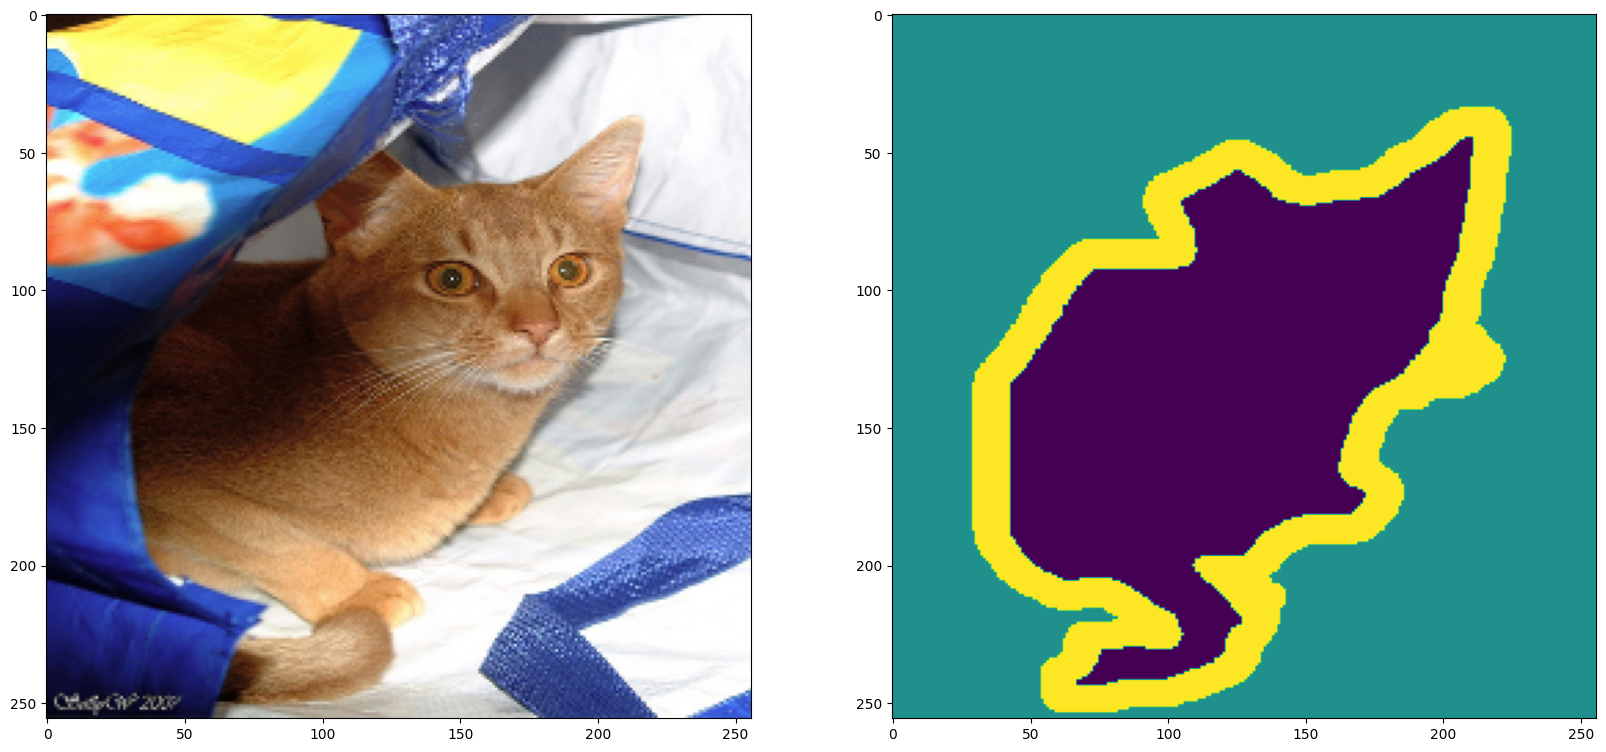

In [4]:
train_ds = CustomOxFordPet(split = 'trainval')
test_ds = CustomOxFordPet(split = 'test')

print(len(train_ds))
print(len(test_ds))

for idx in range(1):
    img, target = train_ds[idx]

    print(f"Image Shape/Dtype: {img.shape}/{img.dtype}")
    for key in target:
        if isinstance(target[key], int):
            print(f"{key}: {target[key]}")
        else:
            print(f"{key} Shape/Dtype: {target[key].shape}/{target[key].dtype}")

    img = invnorm(img)
    img_np = img.permute(1, -1, 0).numpy()

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img_np)
    axarr[1].imshow(torch.argmax(target['semantic'], dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [5]:
extra_train_ds, valid_ds, test_ds = random_split(test_ds, [0.8, 0.1, 0.1])
valid_ds.mode = 'test'
test_ds.mode = 'test'
extra_train_ds.mode = 'train'

train_ds = ConcatDataset([train_ds, extra_train_ds])
print(train_ds.datasets[0].mode)
print(train_ds.datasets[1].mode)
print(valid_ds.mode)
print(test_ds.mode)

print(f"#Training Samples: {len(train_ds)}")
print(f"#Validating Samples: {len(valid_ds)}")
print(f"#Testing Samples: {len(test_ds)}")

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=24)

print(f"Train Batch Samples: {len(train_dl)}")
print(f"Valid Batch Samples: {len(valid_dl)}")
print(f"Test Batch Samples: {len(test_dl)}")

train
train
test
test
#Training Samples: 6616
#Validating Samples: 367
#Testing Samples: 366
Train Batch Samples: 104
Valid Batch Samples: 6
Test Batch Samples: 6


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class GlobalAvgPooling(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()

    def forward(self, x):
        return x.mean(dim=(2, 3))

In [11]:
class OxFordPetUnet(nn.Module):
    def __init__(self, n_channels, seg_n_classes, cls_n_classes, init_ch=32):
        super(OxFordPetUnet, self).__init__()
        self.seg_n_classes = seg_n_classes
        self.cls_n_classes = cls_n_classes
        self.init_ch = init_ch

        self.encoder = nn.Sequential(
            DoubleConv(n_channels, self.init_ch),
            Down(self.init_ch, self.init_ch*2),
            Down(self.init_ch*2, self.init_ch*4),
            Down(self.init_ch*4, self.init_ch*8),
            Down(self.init_ch*8, self.init_ch*16)
        )

        self.encoder = nn.ModuleList(
            [
                DoubleConv(n_channels, self.init_ch),
                Down(self.init_ch, self.init_ch*2),
                Down(self.init_ch*2, self.init_ch*4),
                Down(self.init_ch*4, self.init_ch*8),
                Down(self.init_ch*8, self.init_ch*16)
            ]
        )

        self.decoder = nn.ModuleDict(
            {
                "cls" : nn.Sequential(
                    Down(self.init_ch*16, self.init_ch*24),
                    GlobalAvgPooling(),
                    nn.Linear(self.init_ch*24, 256),
                    nn.ReLU(),
                    nn.Linear(256, self.cls_n_classes)
                ),
                "seg" : nn.ModuleList(
                    [
                        Up(self.init_ch*16, self.init_ch*8),
                        Up(self.init_ch*8, self.init_ch*4),
                        Up(self.init_ch*4, self.init_ch*2),
                        Up(self.init_ch*2, self.init_ch),
                        OutConv(self.init_ch, self.seg_n_classes)
                    ]
                )
            }
        )

    def forward(self, x):
        x1 = self.encoder[0](x)
        x2 = self.encoder[1](x1)
        x3 = self.encoder[2](x2)
        x4 = self.encoder[3](x3)
        x5 = self.encoder[4](x4)
        
        x = self.decoder['seg'][0](x5, x4)
        x = self.decoder['seg'][1](x, x3)
        x = self.decoder['seg'][2](x, x2)
        x = self.decoder['seg'][3](x, x1)
        
        logits = self.decoder['cls'](x5)
        masks = self.decoder['seg'][4](x)
        return logits, masks

In [12]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [13]:
def miou(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = torch.argmax(mask, dim=1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = OxFordPetUnet(n_channels=3, seg_n_classes=3, cls_n_classes=37, init_ch=32).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

cls_loss_fn = nn.CrossEntropyLoss()
seg_loss_fn = nn.CrossEntropyLoss()

In [15]:
for epoch in range(epochs):
    model.train()
    tr_cls_loss = 0
    tr_seg_loss = 0
    tr_cls_corr = 0 
    tr_seg_corr = 0 
    tr_dce_loss = 0
    tr_iou_score = 0
    
    for train_img, train_target in tqdm(train_dl):
        train_img = train_img.to(device)
        train_label_cate = train_target['category'].to(device)
        train_label_mask = train_target['semantic'].to(device)

        train_logits, train_masks = model(train_img)
        
        train_cls_loss = cls_loss_fn(train_logits, train_label_cate)
        train_seg_loss = seg_loss_fn(train_masks, train_label_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_masks, dim=1).float(),
            train_label_mask.float(),
            multiclass=True
        )
        train_loss = train_cls_loss + train_seg_loss + train_dice_loss
        train_iou = miou(train_masks, train_label_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_cls_loss += train_cls_loss.item()
        tr_seg_loss += train_seg_loss.item()
        tr_dce_loss += train_dice_loss.item()
        tr_iou_score += train_iou.item()
        
        tr_cls_corr += (train_logits.argmax(dim=1) == train_label_cate).sum().item()
        tr_seg_corr += (train_masks.argmax(dim=1) == train_label_mask.argmax(dim=1)).sum().item() / (256 * 256)

    model.eval()
    with torch.no_grad():
        va_cls_loss = 0
        va_seg_loss = 0
        va_cls_corr = 0
        va_seg_corr = 0 
        va_dce_loss = 0
        va_iou_score = 0
        
        for valid_img, valid_target in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_label_cate = valid_target['category'].to(device)
            valid_label_mask = valid_target['semantic'].to(device)
            
            valid_logits, valid_masks = model(valid_img)
            
            valid_cls_loss = cls_loss_fn(valid_logits, valid_label_cate)
            valid_seg_loss = seg_loss_fn(valid_masks, valid_label_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_masks, dim=1).float(),
                valid_label_mask.float(),
                multiclass=True
            )
            valid_iou = miou(valid_masks, valid_label_mask)

            va_cls_loss += valid_cls_loss.item()
            va_seg_loss += valid_seg_loss.item()
            va_dce_loss += valid_dice_loss.item()
            va_iou_score += valid_iou.item()
            
            va_cls_corr += (valid_logits.argmax(dim=1) == valid_label_cate).sum().item()
            va_seg_corr += (valid_masks.argmax(dim=1) == valid_label_mask.argmax(dim=1)).sum().item() / (256 * 256)
            
    mean_train_cls_loss = tr_cls_loss/len(train_dl)
    mean_train_seg_loss = tr_seg_loss/len(train_dl)
    mean_valid_cls_loss = va_cls_loss/len(valid_dl)
    mean_valid_seg_loss = va_seg_loss/len(valid_dl)

    mean_train_cls_corr = tr_cls_corr/len(train_ds)
    mean_valid_cls_corr = va_cls_corr/len(valid_ds)

    mean_train_seg_corr = tr_seg_corr/len(train_ds)
    mean_valid_seg_corr = va_seg_corr/len(valid_ds)

    mean_train_dce_loss = tr_dce_loss/len(train_dl)
    mean_valid_dce_loss = va_dce_loss/len(valid_dl)

    mean_train_iou_score = tr_iou_score/len(train_dl)
    mean_valid_iou_score = va_iou_score/len(valid_dl)

    print(f"Epoch: {epoch} - Train - SegLoss: {mean_train_seg_loss} - ClsLoss: {mean_train_cls_loss} - DiceLoss: {mean_train_dce_loss}")
    print(f"Epoch: {epoch} - Train - ClsCorr: {mean_train_cls_corr} - SegCorr: {mean_train_seg_corr} - IouScore: {mean_train_iou_score}")
    
    print(f"Epoch: {epoch} - Valid - SegLoss: {mean_valid_seg_loss} - ClsLoss: {mean_valid_cls_loss} - DiceLoss: {mean_valid_dce_loss}")
    print(f"Epoch: {epoch} - Valid - ClsCorr: {mean_valid_cls_corr} - SegCorr: {mean_valid_seg_corr} - IouScore: {mean_valid_iou_score}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 0 - Train - SegLoss: 0.7560931581717271 - ClsLoss: 3.5265122331105747 - DiceLoss: 0.4347920371935918
Epoch: 0 - Train - ClsCorr: 0.048821039903264814 - SegCorr: 0.6852148026047767 - IouScore: 0.4079235203178353
Epoch: 0 - Valid - SegLoss: 0.6048225363095602 - ClsLoss: 3.64304248491923 - DiceLoss: 0.3251361350218455
Epoch: 0 - Valid - ClsCorr: 0.021798365122615803 - SegCorr: 0.7639855740830424 - IouScore: 0.4933851387702071


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 1 - Train - SegLoss: 0.5642252295063093 - ClsLoss: 3.227596101852564 - DiceLoss: 0.2898448505080663
Epoch: 1 - Train - ClsCorr: 0.09159613059250302 - SegCorr: 0.7815395618148121 - IouScore: 0.5239446719171293
Epoch: 1 - Valid - SegLoss: 0.5497347811857859 - ClsLoss: 3.1693844397862754 - DiceLoss: 0.2707614103953044
Epoch: 1 - Valid - ClsCorr: 0.11989100817438691 - SegCorr: 0.786665705958894 - IouScore: 0.5545977604650908


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 2 - Train - SegLoss: 0.497674792431868 - ClsLoss: 2.9088206612146816 - DiceLoss: 0.2497449626143162
Epoch: 2 - Train - ClsCorr: 0.1568923821039903 - SegCorr: 0.808605051098308 - IouScore: 0.5720894668350893
Epoch: 2 - Valid - SegLoss: 0.48353645702203113 - ClsLoss: 2.8885852495829263 - DiceLoss: 0.23862297336260477
Epoch: 2 - Valid - ClsCorr: 0.17983651226158037 - SegCorr: 0.8199153141364739 - IouScore: 0.6041893666685101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 3 - Train - SegLoss: 0.462408205637565 - ClsLoss: 2.5898114305276136 - DiceLoss: 0.2300882264971733
Epoch: 3 - Train - ClsCorr: 0.22868802902055624 - SegCorr: 0.8228562872816314 - IouScore: 0.5966286486446281
Epoch: 3 - Valid - SegLoss: 0.511619453628858 - ClsLoss: 2.7836894591649375 - DiceLoss: 0.2371044953664144
Epoch: 3 - Valid - ClsCorr: 0.1771117166212534 - SegCorr: 0.8048466570695675 - IouScore: 0.5698718627533503


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 4 - Train - SegLoss: 0.42806772285929096 - ClsLoss: 2.292099496492973 - DiceLoss: 0.2117727049268209
Epoch: 4 - Train - ClsCorr: 0.2941354292623942 - SegCorr: 0.8369749569691078 - IouScore: 0.6182689235628216
Epoch: 4 - Valid - SegLoss: 0.4549422711133957 - ClsLoss: 3.221978227297465 - DiceLoss: 0.2199146846930186
Epoch: 4 - Valid - ClsCorr: 0.18528610354223432 - SegCorr: 0.8268342810690565 - IouScore: 0.6213843242607779


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 5 - Train - SegLoss: 0.4092817773612646 - ClsLoss: 2.1175891860173297 - DiceLoss: 0.20180952892853662
Epoch: 5 - Train - ClsCorr: 0.3273881499395405 - SegCorr: 0.84469378700856 - IouScore: 0.6332295496519331
Epoch: 5 - Valid - SegLoss: 0.4088284522294998 - ClsLoss: 2.79733677705129 - DiceLoss: 0.19083752234776816
Epoch: 5 - Valid - ClsCorr: 0.2724795640326976 - SegCorr: 0.8485232984662381 - IouScore: 0.6511318623815101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 6 - Train - SegLoss: 0.38044984352130157 - ClsLoss: 1.8898568886976976 - DiceLoss: 0.1872161036500564
Epoch: 6 - Train - ClsCorr: 0.3970677146311971 - SegCorr: 0.8559514568102835 - IouScore: 0.6526798989404282
Epoch: 6 - Valid - SegLoss: 0.3780360867579778 - ClsLoss: 2.287932793299357 - DiceLoss: 0.18175344665845236
Epoch: 6 - Valid - ClsCorr: 0.35967302452316074 - SegCorr: 0.859606043844197 - IouScore: 0.6652156554169151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 7 - Train - SegLoss: 0.37257517358431447 - ClsLoss: 1.736373402751409 - DiceLoss: 0.1826875490637926
Epoch: 7 - Train - ClsCorr: 0.4351571946795647 - SegCorr: 0.8591034922663217 - IouScore: 0.6582052130742858
Epoch: 7 - Valid - SegLoss: 0.37100264926751453 - ClsLoss: 2.266746401786804 - DiceLoss: 0.1803476313749949
Epoch: 7 - Valid - ClsCorr: 0.3079019073569482 - SegCorr: 0.859677722733417 - IouScore: 0.6676732996721938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 8 - Train - SegLoss: 0.358156776198974 - ClsLoss: 1.5750141006249647 - DiceLoss: 0.1746451063798024
Epoch: 8 - Train - ClsCorr: 0.4841293833131802 - SegCorr: 0.8655234686264536 - IouScore: 0.6699960778820024
Epoch: 8 - Valid - SegLoss: 0.3542673935492833 - ClsLoss: 2.5722113847732544 - DiceLoss: 0.1745246946811676
Epoch: 8 - Valid - ClsCorr: 0.3188010899182561 - SegCorr: 0.8662256557869976 - IouScore: 0.6754788380242115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 9 - Train - SegLoss: 0.34710523314200914 - ClsLoss: 1.41678263934759 - DiceLoss: 0.16952202297174013
Epoch: 9 - Train - ClsCorr: 0.5371825876662636 - SegCorr: 0.8690730790273166 - IouScore: 0.6768125496420758
Epoch: 9 - Valid - SegLoss: 0.40494171778361004 - ClsLoss: 2.281329611937205 - DiceLoss: 0.2150844931602478
Epoch: 9 - Valid - ClsCorr: 0.3569482288828338 - SegCorr: 0.8469539715093878 - IouScore: 0.6661011528291988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 10 - Train - SegLoss: 0.337447257569203 - ClsLoss: 1.267450027167797 - DiceLoss: 0.1646466111907592
Epoch: 10 - Train - ClsCorr: 0.5785973397823458 - SegCorr: 0.8730318145567445 - IouScore: 0.6843730004762448
Epoch: 10 - Valid - SegLoss: 0.32616447408994037 - ClsLoss: 2.9963857730229697 - DiceLoss: 0.16627689202626547
Epoch: 10 - Valid - ClsCorr: 0.28610354223433243 - SegCorr: 0.8764826387410593 - IouScore: 0.6936486181334107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch: 11 - Train - SegLoss: 0.32904736124552214 - ClsLoss: 1.1443924491222088 - DiceLoss: 0.16060602951508302
Epoch: 11 - Train - ClsCorr: 0.6172914147521161 - SegCorr: 0.876534859819885 - IouScore: 0.6902674450247612
Epoch: 11 - Valid - SegLoss: 0.38493143022060394 - ClsLoss: 1.8374628225962322 - DiceLoss: 0.16739749908447266
Epoch: 11 - Valid - ClsCorr: 0.47956403269754766 - SegCorr: 0.8639945879944014 - IouScore: 0.6770193722383201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 12 - Train - SegLoss: 0.3224789036008028 - ClsLoss: 1.0170182694609349 - DiceLoss: 0.15601502530849898
Epoch: 12 - Train - ClsCorr: 0.6541717049576784 - SegCorr: 0.8794303718760628 - IouScore: 0.6956653837119334
Epoch: 12 - Valid - SegLoss: 0.41643619537353516 - ClsLoss: 2.5911426544189453 - DiceLoss: 0.18301288286844888
Epoch: 12 - Valid - ClsCorr: 0.39509536784741145 - SegCorr: 0.8512797342659018 - IouScore: 0.654207453429757


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 13 - Train - SegLoss: 0.31556738153673136 - ClsLoss: 0.9533420703732051 - DiceLoss: 0.15375643510084885
Epoch: 13 - Train - ClsCorr: 0.6794135429262395 - SegCorr: 0.8816300660840257 - IouScore: 0.7003852377822006
Epoch: 13 - Valid - SegLoss: 0.31194624801476795 - ClsLoss: 1.7613132794698079 - DiceLoss: 0.15895846486091614
Epoch: 13 - Valid - ClsCorr: 0.5122615803814714 - SegCorr: 0.8810792346091622 - IouScore: 0.7079581309744297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 14 - Train - SegLoss: 0.3065776859338467 - ClsLoss: 0.8328398471841445 - DiceLoss: 0.14917836968715376
Epoch: 14 - Train - ClsCorr: 0.720677146311971 - SegCorr: 0.885027086287917 - IouScore: 0.706035368755112
Epoch: 14 - Valid - SegLoss: 0.32324153184890747 - ClsLoss: 1.6359193325042725 - DiceLoss: 0.15124642848968506
Epoch: 14 - Valid - ClsCorr: 0.5613079019073569 - SegCorr: 0.8795504868842601 - IouScore: 0.7017130943679083


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 15 - Train - SegLoss: 0.30219860174334967 - ClsLoss: 0.7600174145056651 - DiceLoss: 0.14689927433545774
Epoch: 15 - Train - ClsCorr: 0.7496977025392987 - SegCorr: 0.8867467859491904 - IouScore: 0.7098914474723741
Epoch: 15 - Valid - SegLoss: 0.2961842715740204 - ClsLoss: 1.6654640436172485 - DiceLoss: 0.14579723278681436
Epoch: 15 - Valid - ClsCorr: 0.55858310626703 - SegCorr: 0.8884331393956488 - IouScore: 0.714196016543751


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 16 - Train - SegLoss: 0.2904526203011091 - ClsLoss: 0.6644242147986705 - DiceLoss: 0.14151858996886474
Epoch: 16 - Train - ClsCorr: 0.7723700120918985 - SegCorr: 0.8908466514393669 - IouScore: 0.7166639212320517
Epoch: 16 - Valid - SegLoss: 0.30426667133967084 - ClsLoss: 1.9305553237597148 - DiceLoss: 0.14616485436757407
Epoch: 16 - Valid - ClsCorr: 0.5258855585831063 - SegCorr: 0.8854179694152333 - IouScore: 0.7146966524872722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 17 - Train - SegLoss: 0.2951937989833263 - ClsLoss: 0.6188036280755813 - DiceLoss: 0.14311715673941833
Epoch: 17 - Train - ClsCorr: 0.7885429262394196 - SegCorr: 0.889507468983513 - IouScore: 0.7157412548462665
Epoch: 17 - Valid - SegLoss: 0.2996565252542496 - ClsLoss: 2.1440505186716714 - DiceLoss: 0.14399288098017374
Epoch: 17 - Valid - ClsCorr: 0.44959128065395093 - SegCorr: 0.8868164977195803 - IouScore: 0.7099277556881965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 18 - Train - SegLoss: 0.2859303349485764 - ClsLoss: 0.569582252834852 - DiceLoss: 0.13876035121771005
Epoch: 18 - Train - ClsCorr: 0.8110640870616687 - SegCorr: 0.8931023414362731 - IouScore: 0.7213208760680785
Epoch: 18 - Valid - SegLoss: 0.3068595627943675 - ClsLoss: 2.2000300089518228 - DiceLoss: 0.15666373570760092
Epoch: 18 - Valid - ClsCorr: 0.48501362397820164 - SegCorr: 0.8834834293708489 - IouScore: 0.710828407532595


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 19 - Train - SegLoss: 0.28298813634766984 - ClsLoss: 0.5171715382200021 - DiceLoss: 0.1374946483052694
Epoch: 19 - Train - ClsCorr: 0.8243651753325272 - SegCorr: 0.8941064878415312 - IouScore: 0.7235764403061941
Epoch: 19 - Valid - SegLoss: 0.304400235414505 - ClsLoss: 1.9064314166704814 - DiceLoss: 0.14351521929105124
Epoch: 19 - Valid - ClsCorr: 0.5367847411444142 - SegCorr: 0.8876302443668044 - IouScore: 0.7204257870659118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 20 - Train - SegLoss: 0.2759108513307113 - ClsLoss: 0.4571487884968519 - DiceLoss: 0.13446915207000879
Epoch: 20 - Train - ClsCorr: 0.8523276904474002 - SegCorr: 0.8963017792338471 - IouScore: 0.7274910514352795
Epoch: 20 - Valid - SegLoss: 0.2909204512834549 - ClsLoss: 1.7969032128651936 - DiceLoss: 0.14219980438550314
Epoch: 20 - Valid - ClsCorr: 0.5367847411444142 - SegCorr: 0.8915549545911742 - IouScore: 0.7262477966734657


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 21 - Train - SegLoss: 0.27465453486029917 - ClsLoss: 0.3915857350310454 - DiceLoss: 0.1335049787392983
Epoch: 21 - Train - ClsCorr: 0.8685006045949214 - SegCorr: 0.8968481827243496 - IouScore: 0.7293348036881446
Epoch: 21 - Valid - SegLoss: 0.274924598634243 - ClsLoss: 1.8034876982371013 - DiceLoss: 0.1423563857873281
Epoch: 21 - Valid - ClsCorr: 0.5749318801089919 - SegCorr: 0.895222011638922 - IouScore: 0.7342954973335104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 22 - Train - SegLoss: 0.2715427247950664 - ClsLoss: 0.3827518376593406 - DiceLoss: 0.1320373794207206
Epoch: 22 - Train - ClsCorr: 0.867744860943168 - SegCorr: 0.8984492715930131 - IouScore: 0.7319420979717971
Epoch: 22 - Valid - SegLoss: 0.28912922739982605 - ClsLoss: 1.283701241016388 - DiceLoss: 0.13554019729296365
Epoch: 22 - Valid - ClsCorr: 0.662125340599455 - SegCorr: 0.8931394987600051 - IouScore: 0.727499017415039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 23 - Train - SegLoss: 0.26251544430851936 - ClsLoss: 0.31801690096752 - DiceLoss: 0.1273135021328926
Epoch: 23 - Train - ClsCorr: 0.8943470374848851 - SegCorr: 0.9017853073802796 - IouScore: 0.738088905061531
Epoch: 23 - Valid - SegLoss: 0.27551529308160144 - ClsLoss: 1.9707693854967754 - DiceLoss: 0.1322581668694814
Epoch: 23 - Valid - ClsCorr: 0.5722070844686649 - SegCorr: 0.8965879435110482 - IouScore: 0.7347354328033058


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 24 - Train - SegLoss: 0.26197889547508496 - ClsLoss: 0.291791251502358 - DiceLoss: 0.1271848243016463
Epoch: 24 - Train - ClsCorr: 0.9040205562273277 - SegCorr: 0.9020475689704646 - IouScore: 0.7388685509727824
Epoch: 24 - Valid - SegLoss: 0.27954338242610294 - ClsLoss: 1.3707512219746907 - DiceLoss: 0.1313074231147766
Epoch: 24 - Valid - ClsCorr: 0.6376021798365122 - SegCorr: 0.8964968065474923 - IouScore: 0.7364219619221983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 25 - Train - SegLoss: 0.2585610978018779 - ClsLoss: 0.2641969747268237 - DiceLoss: 0.12553565032207048
Epoch: 25 - Train - ClsCorr: 0.912031438935913 - SegCorr: 0.9034560640604925 - IouScore: 0.7411730821618127
Epoch: 25 - Valid - SegLoss: 0.2791216696302096 - ClsLoss: 1.3653514285882313 - DiceLoss: 0.12990585962931314
Epoch: 25 - Valid - ClsCorr: 0.6730245231607629 - SegCorr: 0.8969774791915021 - IouScore: 0.7370277727320559


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 26 - Train - SegLoss: 0.25546342607301015 - ClsLoss: 0.2735810263368946 - DiceLoss: 0.12403108294193561
Epoch: 26 - Train - ClsCorr: 0.9114268440145102 - SegCorr: 0.9046351560802529 - IouScore: 0.7441544977342159
Epoch: 26 - Valid - SegLoss: 0.2858150452375412 - ClsLoss: 1.4353595276673634 - DiceLoss: 0.1323502461115519
Epoch: 26 - Valid - ClsCorr: 0.6348773841961853 - SegCorr: 0.8928573982592175 - IouScore: 0.727593794884105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 27 - Train - SegLoss: 0.25145728642550796 - ClsLoss: 0.21701378203355348 - DiceLoss: 0.12171480403496669
Epoch: 27 - Train - ClsCorr: 0.9303204353083434 - SegCorr: 0.9062016520563607 - IouScore: 0.7470004823109565
Epoch: 27 - Valid - SegLoss: 0.28164438406626385 - ClsLoss: 1.5211514433224995 - DiceLoss: 0.13126816352208456
Epoch: 27 - Valid - ClsCorr: 0.6348773841961853 - SegCorr: 0.8964459577763113 - IouScore: 0.7363021889156388


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 28 - Train - SegLoss: 0.24718312618251032 - ClsLoss: 0.20527042677769294 - DiceLoss: 0.12032437439148243
Epoch: 28 - Train - ClsCorr: 0.9330411124546554 - SegCorr: 0.9075997639740249 - IouScore: 0.7497471302866768
Epoch: 28 - Valid - SegLoss: 0.26990587015946704 - ClsLoss: 1.338981608549754 - DiceLoss: 0.13091552257537842
Epoch: 28 - Valid - ClsCorr: 0.662125340599455 - SegCorr: 0.8984965810334 - IouScore: 0.7379653463156229


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 29 - Train - SegLoss: 0.2435914733662055 - ClsLoss: 0.1905812445239952 - DiceLoss: 0.11834533340655841
Epoch: 29 - Train - ClsCorr: 0.9375755743651754 - SegCorr: 0.9090015083875737 - IouScore: 0.7525909051788329
Epoch: 29 - Valid - SegLoss: 0.27494296928246814 - ClsLoss: 2.0849446058273315 - DiceLoss: 0.12648902336756387
Epoch: 29 - Valid - ClsCorr: 0.5749318801089919 - SegCorr: 0.8996541285709724 - IouScore: 0.7411306966942801


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 30 - Train - SegLoss: 0.2421381645477735 - ClsLoss: 0.17144449176983192 - DiceLoss: 0.11722956998990132
Epoch: 30 - Train - ClsCorr: 0.9425634824667473 - SegCorr: 0.9096428941498357 - IouScore: 0.7541330923960129
Epoch: 30 - Valid - SegLoss: 0.2706342289845149 - ClsLoss: 1.1946430106957753 - DiceLoss: 0.1267592509587606
Epoch: 30 - Valid - ClsCorr: 0.7057220708446866 - SegCorr: 0.9021830130013199 - IouScore: 0.7464158463666761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 31 - Train - SegLoss: 0.23614488255519134 - ClsLoss: 0.18454262202319044 - DiceLoss: 0.1146083244910607
Epoch: 31 - Train - ClsCorr: 0.9387847642079806 - SegCorr: 0.9117633261444202 - IouScore: 0.7582214826134188
Epoch: 31 - Valid - SegLoss: 0.26877299944559735 - ClsLoss: 1.498930831750234 - DiceLoss: 0.12927736838658652
Epoch: 31 - Valid - ClsCorr: 0.6566757493188011 - SegCorr: 0.8994718130667788 - IouScore: 0.744502070510369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 32 - Train - SegLoss: 0.2354508601129055 - ClsLoss: 0.1404529613478539 - DiceLoss: 0.11383864455498181
Epoch: 32 - Train - ClsCorr: 0.9552599758162031 - SegCorr: 0.9124297127037556 - IouScore: 0.7594799065358795
Epoch: 32 - Valid - SegLoss: 0.25872862587372464 - ClsLoss: 1.4621654152870178 - DiceLoss: 0.12208716074625652
Epoch: 32 - Valid - ClsCorr: 0.6811989100817438 - SegCorr: 0.9035526452337364 - IouScore: 0.7487866993266133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 33 - Train - SegLoss: 0.23076398985890242 - ClsLoss: 0.14102364560732475 - DiceLoss: 0.11246563780766267
Epoch: 33 - Train - ClsCorr: 0.9513301088270859 - SegCorr: 0.9135624310125607 - IouScore: 0.762171763929635
Epoch: 33 - Valid - SegLoss: 0.2680232475201289 - ClsLoss: 1.5224828918774922 - DiceLoss: 0.1231098473072052
Epoch: 33 - Valid - ClsCorr: 0.6566757493188011 - SegCorr: 0.9011706526337917 - IouScore: 0.7452218388256363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch: 34 - Train - SegLoss: 0.22919941063110644 - ClsLoss: 0.12744978351446873 - DiceLoss: 0.11124070217976204
Epoch: 34 - Train - ClsCorr: 0.9597944377267231 - SegCorr: 0.9143184537322518 - IouScore: 0.7635717421050934
Epoch: 34 - Valid - SegLoss: 0.2565227523446083 - ClsLoss: 1.5478339195251465 - DiceLoss: 0.12064499656359355
Epoch: 34 - Valid - ClsCorr: 0.659400544959128 - SegCorr: 0.9044780263459 - IouScore: 0.7519487938963026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 35 - Train - SegLoss: 0.22596821590111807 - ClsLoss: 0.1075294861713281 - DiceLoss: 0.10959761990950657
Epoch: 35 - Train - ClsCorr: 0.9682587666263603 - SegCorr: 0.9154983552796665 - IouScore: 0.7661420342631295
Epoch: 35 - Valid - SegLoss: 0.2554320494333903 - ClsLoss: 1.6981873710950215 - DiceLoss: 0.1212268869082133
Epoch: 35 - Valid - ClsCorr: 0.6239782016348774 - SegCorr: 0.9054760841972497 - IouScore: 0.7513566337398632


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 36 - Train - SegLoss: 0.22235083680313367 - ClsLoss: 0.11190593554280125 - DiceLoss: 0.10823195141095382
Epoch: 36 - Train - ClsCorr: 0.9587363966142685 - SegCorr: 0.9168175716930607 - IouScore: 0.7686850652181373
Epoch: 36 - Valid - SegLoss: 0.26809533933798474 - ClsLoss: 1.5424267848332722 - DiceLoss: 0.1209007203578949
Epoch: 36 - Valid - ClsCorr: 0.667574931880109 - SegCorr: 0.9019406601908422 - IouScore: 0.7453111894859026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 37 - Train - SegLoss: 0.21992751182271883 - ClsLoss: 0.1030955579615413 - DiceLoss: 0.10660439385817601
Epoch: 37 - Train - ClsCorr: 0.9664449818621523 - SegCorr: 0.9180129511324642 - IouScore: 0.7707353201945207
Epoch: 37 - Valid - SegLoss: 0.2701337734858195 - ClsLoss: 1.4880251288414001 - DiceLoss: 0.11923156181971233
Epoch: 37 - Valid - ClsCorr: 0.7166212534059946 - SegCorr: 0.903691803726903 - IouScore: 0.7493128162197614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 38 - Train - SegLoss: 0.21580031972665054 - ClsLoss: 0.08401517595092838 - DiceLoss: 0.10489959670947148
Epoch: 38 - Train - ClsCorr: 0.9721886336154776 - SegCorr: 0.9193326841674953 - IouScore: 0.7741658619201541
Epoch: 38 - Valid - SegLoss: 0.25806858638922375 - ClsLoss: 1.401147574186325 - DiceLoss: 0.11724930008252461
Epoch: 38 - Valid - ClsCorr: 0.7275204359673024 - SegCorr: 0.906166679527844 - IouScore: 0.756543907052853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 39 - Train - SegLoss: 0.2140811878041579 - ClsLoss: 0.09076496601427117 - DiceLoss: 0.10421638534619258
Epoch: 39 - Train - ClsCorr: 0.9721886336154776 - SegCorr: 0.9198443771417657 - IouScore: 0.7745038627211887
Epoch: 39 - Valid - SegLoss: 0.26750953247149784 - ClsLoss: 1.3034235139687855 - DiceLoss: 0.1181102991104126
Epoch: 39 - Valid - ClsCorr: 0.7329700272479565 - SegCorr: 0.9039220576065438 - IouScore: 0.7488391874607802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch: 40 - Train - SegLoss: 0.21109724832841983 - ClsLoss: 0.0876242731554577 - DiceLoss: 0.10296380175993992
Epoch: 40 - Train - ClsCorr: 0.9685610640870617 - SegCorr: 0.9208880289578236 - IouScore: 0.7766851027457673
Epoch: 40 - Valid - SegLoss: 0.2621781677007675 - ClsLoss: 2.351280152797699 - DiceLoss: 0.11334213614463806
Epoch: 40 - Valid - ClsCorr: 0.5912806539509536 - SegCorr: 0.9074223074016519 - IouScore: 0.7535358937668614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 41 - Train - SegLoss: 0.2097940596823509 - ClsLoss: 0.08447701076511294 - DiceLoss: 0.10158696541419396
Epoch: 41 - Train - ClsCorr: 0.973397823458283 - SegCorr: 0.9218862780348421 - IouScore: 0.77900682339362
Epoch: 41 - Valid - SegLoss: 0.26083599030971527 - ClsLoss: 1.1642792622248332 - DiceLoss: 0.11421957612037659
Epoch: 41 - Valid - ClsCorr: 0.7438692098092643 - SegCorr: 0.9074561095692482 - IouScore: 0.7595076851387373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 42 - Train - SegLoss: 0.20567647396371916 - ClsLoss: 0.0680263949638734 - DiceLoss: 0.09988353859919769
Epoch: 42 - Train - ClsCorr: 0.9798972188633616 - SegCorr: 0.9232642440150122 - IouScore: 0.7814032694590962
Epoch: 42 - Valid - SegLoss: 0.26473357776800793 - ClsLoss: 1.2164379358291626 - DiceLoss: 0.1139883001645406
Epoch: 42 - Valid - ClsCorr: 0.7002724795640327 - SegCorr: 0.9058332729079743 - IouScore: 0.7534767017137081


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 43 - Train - SegLoss: 0.20455147727177694 - ClsLoss: 0.08143128492296316 - DiceLoss: 0.09974507930187079
Epoch: 43 - Train - ClsCorr: 0.9737001209189843 - SegCorr: 0.923406490247512 - IouScore: 0.7823263479789352
Epoch: 43 - Valid - SegLoss: 0.2720302492380142 - ClsLoss: 1.3106692135334015 - DiceLoss: 0.11763296524683635
Epoch: 43 - Valid - ClsCorr: 0.7193460490463215 - SegCorr: 0.9042472319641944 - IouScore: 0.7556305357155207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 44 - Train - SegLoss: 0.20449465054732102 - ClsLoss: 0.07078061114925031 - DiceLoss: 0.09901488285798293
Epoch: 44 - Train - ClsCorr: 0.9791414752116082 - SegCorr: 0.923966858666638 - IouScore: 0.7832361582526518
Epoch: 44 - Valid - SegLoss: 0.25460512687762576 - ClsLoss: 1.0863055189450581 - DiceLoss: 0.11237788200378418
Epoch: 44 - Valid - ClsCorr: 0.7465940054495913 - SegCorr: 0.908865323183647 - IouScore: 0.7583749162772001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 45 - Train - SegLoss: 0.19834113794450575 - ClsLoss: 0.06652129893280709 - DiceLoss: 0.09706774525917493
Epoch: 45 - Train - ClsCorr: 0.9791414752116082 - SegCorr: 0.9256237703482502 - IouScore: 0.7868056220925435
Epoch: 45 - Valid - SegLoss: 0.25072818001111347 - ClsLoss: 1.1497918367385864 - DiceLoss: 0.11156818270683289
Epoch: 45 - Valid - ClsCorr: 0.7247956403269755 - SegCorr: 0.909153577092558 - IouScore: 0.761091399537139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 46 - Train - SegLoss: 0.19470173621980044 - ClsLoss: 0.047984114749572024 - DiceLoss: 0.09435910559617557
Epoch: 46 - Train - ClsCorr: 0.9854897218863361 - SegCorr: 0.9272905970138678 - IouScore: 0.7905098324366884
Epoch: 46 - Valid - SegLoss: 0.2511374428868294 - ClsLoss: 1.2840284407138824 - DiceLoss: 0.11354145407676697
Epoch: 46 - Valid - ClsCorr: 0.7411444141689373 - SegCorr: 0.9095580805225009 - IouScore: 0.7641732067495915


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch: 47 - Train - SegLoss: 0.18913783018405622 - ClsLoss: 0.03957392985466868 - DiceLoss: 0.09243312478065491
Epoch: 47 - Train - ClsCorr: 0.9874546553808948 - SegCorr: 0.9291571417627484 - IouScore: 0.7941266810176858
Epoch: 47 - Valid - SegLoss: 0.2575700084368388 - ClsLoss: 1.400834560394287 - DiceLoss: 0.11251925428708394
Epoch: 47 - Valid - ClsCorr: 0.7166212534059946 - SegCorr: 0.9087639582579402 - IouScore: 0.7621838170195344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 48 - Train - SegLoss: 0.18757722526788712 - ClsLoss: 0.04354828900362078 - DiceLoss: 0.09158459248451087
Epoch: 48 - Train - ClsCorr: 0.9859431680773881 - SegCorr: 0.929586239852813 - IouScore: 0.7953648966310942
Epoch: 48 - Valid - SegLoss: 0.25175608197848004 - ClsLoss: 1.122493326663971 - DiceLoss: 0.11069822311401367
Epoch: 48 - Valid - ClsCorr: 0.779291553133515 - SegCorr: 0.9100030384531463 - IouScore: 0.7650966608018127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch: 49 - Train - SegLoss: 0.18693429632828787 - ClsLoss: 0.04129947160142295 - DiceLoss: 0.09086755777780826
Epoch: 49 - Train - ClsCorr: 0.9859431680773881 - SegCorr: 0.9300596520863248 - IouScore: 0.796472849779997
Epoch: 49 - Valid - SegLoss: 0.24981668094793955 - ClsLoss: 1.378333439429601 - DiceLoss: 0.10986305276552837
Epoch: 49 - Valid - ClsCorr: 0.7411444141689373 - SegCorr: 0.9107548352483182 - IouScore: 0.7643298808651157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 50 - Train - SegLoss: 0.18486875467575514 - ClsLoss: 0.04035832123078693 - DiceLoss: 0.09010983086549319
Epoch: 50 - Train - ClsCorr: 0.9876058041112454 - SegCorr: 0.9309670195758271 - IouScore: 0.7983012319754071
Epoch: 50 - Valid - SegLoss: 0.2518177106976509 - ClsLoss: 1.2037893533706665 - DiceLoss: 0.10870806376139323
Epoch: 50 - Valid - ClsCorr: 0.7329700272479565 - SegCorr: 0.9118789548120316 - IouScore: 0.7680919802418291


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 51 - Train - SegLoss: 0.18131254627727544 - ClsLoss: 0.05358037157342411 - DiceLoss: 0.08862303885129783
Epoch: 51 - Train - ClsCorr: 0.9841293833131801 - SegCorr: 0.9317311029768625 - IouScore: 0.7998573555218754
Epoch: 51 - Valid - SegLoss: 0.24587412178516388 - ClsLoss: 1.2741995652516682 - DiceLoss: 0.105436772108078
Epoch: 51 - Valid - ClsCorr: 0.7411444141689373 - SegCorr: 0.9132524952901482 - IouScore: 0.7695823674327831


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 52 - Train - SegLoss: 0.18189235246525362 - ClsLoss: 0.05059661728088171 - DiceLoss: 0.08914064157467622
Epoch: 52 - Train - ClsCorr: 0.9835247883917775 - SegCorr: 0.9315231858314598 - IouScore: 0.7994547839364577
Epoch: 52 - Valid - SegLoss: 0.24918844550848007 - ClsLoss: 1.0027706424395244 - DiceLoss: 0.10902740557988484
Epoch: 52 - Valid - ClsCorr: 0.782016348773842 - SegCorr: 0.9114766133903482 - IouScore: 0.768598299734386


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch: 53 - Train - SegLoss: 0.17787121136028033 - ClsLoss: 0.03695326142657835 - DiceLoss: 0.08686694388206188
Epoch: 53 - Train - ClsCorr: 0.9886638452237001 - SegCorr: 0.9331215116969043 - IouScore: 0.8032695408657138
Epoch: 53 - Valid - SegLoss: 0.26346085717280704 - ClsLoss: 1.2423792282740276 - DiceLoss: 0.10977721214294434
Epoch: 53 - Valid - ClsCorr: 0.7574931880108992 - SegCorr: 0.909193740553687 - IouScore: 0.7623366219276234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 54 - Train - SegLoss: 0.17130193429497573 - ClsLoss: 0.0211014401104946 - DiceLoss: 0.08386543507759388
Epoch: 54 - Train - ClsCorr: 0.9938029020556227 - SegCorr: 0.9355606092939642 - IouScore: 0.8082279133409114
Epoch: 54 - Valid - SegLoss: 0.24927235146363577 - ClsLoss: 1.10211447874705 - DiceLoss: 0.10423314571380615
Epoch: 54 - Valid - ClsCorr: 0.7683923705722071 - SegCorr: 0.9145122808721475 - IouScore: 0.7719963724291526


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 55 - Train - SegLoss: 0.17030074862906566 - ClsLoss: 0.02297722707198073 - DiceLoss: 0.08312275661871983
Epoch: 55 - Train - ClsCorr: 0.994105199516324 - SegCorr: 0.9362274871051239 - IouScore: 0.8094817344211399
Epoch: 55 - Valid - SegLoss: 0.25016435235738754 - ClsLoss: 1.108613242705663 - DiceLoss: 0.10371289650599162
Epoch: 55 - Valid - ClsCorr: 0.7901907356948229 - SegCorr: 0.9142535466913956 - IouScore: 0.7717219426089494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 56 - Train - SegLoss: 0.16707012257896936 - ClsLoss: 0.022236850070140254 - DiceLoss: 0.08243619020168598
Epoch: 56 - Train - ClsCorr: 0.9933494558645707 - SegCorr: 0.9367636227405922 - IouScore: 0.8106378912773589
Epoch: 56 - Valid - SegLoss: 0.262520506978035 - ClsLoss: 1.392009715239207 - DiceLoss: 0.10254111886024475
Epoch: 56 - Valid - ClsCorr: 0.7656675749318801 - SegCorr: 0.9138965658660806 - IouScore: 0.7680998384627108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 57 - Train - SegLoss: 0.16662315795054802 - ClsLoss: 0.022675170012427352 - DiceLoss: 0.08146209499010673
Epoch: 57 - Train - ClsCorr: 0.994105199516324 - SegCorr: 0.9373995170916151 - IouScore: 0.8124332702486948
Epoch: 57 - Valid - SegLoss: 0.2613667696714401 - ClsLoss: 1.1761087377866108 - DiceLoss: 0.10508777697881062
Epoch: 57 - Valid - ClsCorr: 0.773841961852861 - SegCorr: 0.9128040864617039 - IouScore: 0.767196425626015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 58 - Train - SegLoss: 0.16641911993233058 - ClsLoss: 0.022221748090277497 - DiceLoss: 0.08148023715386024
Epoch: 58 - Train - ClsCorr: 0.9942563482466747 - SegCorr: 0.9373204232415381 - IouScore: 0.8125195780985711
Epoch: 58 - Valid - SegLoss: 0.25397823254267377 - ClsLoss: 1.129071185986201 - DiceLoss: 0.10302353898684184
Epoch: 58 - Valid - ClsCorr: 0.771117166212534 - SegCorr: 0.9141538032718836 - IouScore: 0.7730208393509517


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 59 - Train - SegLoss: 0.16095517919613764 - ClsLoss: 0.015325639340936994 - DiceLoss: 0.07927692624238822
Epoch: 59 - Train - ClsCorr: 0.9960701330108828 - SegCorr: 0.9391790364644836 - IouScore: 0.8164132720099715
Epoch: 59 - Valid - SegLoss: 0.25817252695560455 - ClsLoss: 1.175974041223526 - DiceLoss: 0.10335874557495117
Epoch: 59 - Valid - ClsCorr: 0.773841961852861 - SegCorr: 0.913643985093452 - IouScore: 0.7704246482711881


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 60 - Train - SegLoss: 0.1579075800971343 - ClsLoss: 0.015508594594743604 - DiceLoss: 0.07792978389905049
Epoch: 60 - Train - ClsCorr: 0.99546553808948 - SegCorr: 0.9401167739259289 - IouScore: 0.8186085417673229
Epoch: 60 - Valid - SegLoss: 0.2579340214530627 - ClsLoss: 1.0393045743306477 - DiceLoss: 0.10369929671287537
Epoch: 60 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9135339721347071 - IouScore: 0.7695276098650868


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 61 - Train - SegLoss: 0.15711961306918126 - ClsLoss: 0.01300091924125669 - DiceLoss: 0.07755525983296908
Epoch: 61 - Train - ClsCorr: 0.9965235792019347 - SegCorr: 0.9405572630618186 - IouScore: 0.8197825038351068
Epoch: 61 - Valid - SegLoss: 0.2531697203715642 - ClsLoss: 1.0308032929897308 - DiceLoss: 0.1022595763206482
Epoch: 61 - Valid - ClsCorr: 0.784741144414169 - SegCorr: 0.9145688672806327 - IouScore: 0.7744612023792344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch: 62 - Train - SegLoss: 0.15600510557683614 - ClsLoss: 0.00891830710427782 - DiceLoss: 0.07651615945192483
Epoch: 62 - Train - ClsCorr: 0.9971281741233373 - SegCorr: 0.9411495882193439 - IouScore: 0.821256348804719
Epoch: 62 - Valid - SegLoss: 0.26010558505853015 - ClsLoss: 0.9853447576363882 - DiceLoss: 0.10451275110244751
Epoch: 62 - Valid - ClsCorr: 0.8065395095367848 - SegCorr: 0.913063153259111 - IouScore: 0.7722759875655143


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch: 63 - Train - SegLoss: 0.15401303066084018 - ClsLoss: 0.009142303530097706 - DiceLoss: 0.0754604832484172
Epoch: 63 - Train - ClsCorr: 0.998186215235792 - SegCorr: 0.9420253333907029 - IouScore: 0.8230923436337996
Epoch: 63 - Valid - SegLoss: 0.25964733709891635 - ClsLoss: 0.9950750271479288 - DiceLoss: 0.10050693154335022
Epoch: 63 - Valid - ClsCorr: 0.8201634877384196 - SegCorr: 0.914764404296875 - IouScore: 0.7725209362670409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 64 - Train - SegLoss: 0.15206317431651628 - ClsLoss: 0.010631342180623995 - DiceLoss: 0.07518871988241489
Epoch: 64 - Train - ClsCorr: 0.9965235792019347 - SegCorr: 0.9422618907481035 - IouScore: 0.8239289948321133
Epoch: 64 - Valid - SegLoss: 0.2567322626709938 - ClsLoss: 1.112698753674825 - DiceLoss: 0.10182065765062968
Epoch: 64 - Valid - ClsCorr: 0.7929155313351499 - SegCorr: 0.9143184485162636 - IouScore: 0.7728713268631178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 65 - Train - SegLoss: 0.15047362231864378 - ClsLoss: 0.008733430579013657 - DiceLoss: 0.07422764312762481
Epoch: 65 - Train - ClsCorr: 0.9980350665054414 - SegCorr: 0.9430523195462763 - IouScore: 0.8254774281918894
Epoch: 65 - Valid - SegLoss: 0.25222419450680417 - ClsLoss: 0.9966035783290863 - DiceLoss: 0.09885906179745992
Epoch: 65 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9161135390279078 - IouScore: 0.7749703396769657


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 66 - Train - SegLoss: 0.14764073247519824 - ClsLoss: 0.01027639413587167 - DiceLoss: 0.0730883410343757
Epoch: 66 - Train - ClsCorr: 0.9969770253929867 - SegCorr: 0.9437827441251263 - IouScore: 0.8270950211222403
Epoch: 66 - Valid - SegLoss: 0.2667760153611501 - ClsLoss: 1.215423007806142 - DiceLoss: 0.10226857662200928
Epoch: 66 - Valid - ClsCorr: 0.7656675749318801 - SegCorr: 0.9135208337768222 - IouScore: 0.7700342492653314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch: 67 - Train - SegLoss: 0.1473888113664893 - ClsLoss: 0.010551533822973188 - DiceLoss: 0.07288891592851052
Epoch: 67 - Train - ClsCorr: 0.9980350665054414 - SegCorr: 0.943937347762674 - IouScore: 0.8276295212324203
Epoch: 67 - Valid - SegLoss: 0.26295531044403714 - ClsLoss: 1.05513729651769 - DiceLoss: 0.10042266050974528
Epoch: 67 - Valid - ClsCorr: 0.8038147138964578 - SegCorr: 0.915049747810052 - IouScore: 0.772183245754429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 68 - Train - SegLoss: 0.14526376543709865 - ClsLoss: 0.012404655838998644 - DiceLoss: 0.0718534800868768
Epoch: 68 - Train - ClsCorr: 0.9960701330108828 - SegCorr: 0.9448389701428119 - IouScore: 0.8295373958303196
Epoch: 68 - Valid - SegLoss: 0.25813504308462143 - ClsLoss: 1.0529107948144276 - DiceLoss: 0.10146866242090861
Epoch: 68 - Valid - ClsCorr: 0.8174386920980926 - SegCorr: 0.9156798900635431 - IouScore: 0.7743016651746778


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 69 - Train - SegLoss: 0.14152956001747113 - ClsLoss: 0.007085988871459939 - DiceLoss: 0.0706148285132188
Epoch: 69 - Train - ClsCorr: 0.9984885126964933 - SegCorr: 0.9458716552808178 - IouScore: 0.8321239893449154
Epoch: 69 - Valid - SegLoss: 0.25794140497843426 - ClsLoss: 1.0326432983080547 - DiceLoss: 0.09922049442927043
Epoch: 69 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9160630228733821 - IouScore: 0.7750220296085626


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 70 - Train - SegLoss: 0.14383203264039296 - ClsLoss: 0.011479902489204856 - DiceLoss: 0.07130256065955529
Epoch: 70 - Train - ClsCorr: 0.9963724304715841 - SegCorr: 0.9451527093889636 - IouScore: 0.8307274527430484
Epoch: 70 - Valid - SegLoss: 0.25821543981631595 - ClsLoss: 1.1587546865145366 - DiceLoss: 0.10153031349182129
Epoch: 70 - Valid - ClsCorr: 0.784741144414169 - SegCorr: 0.9144438449953167 - IouScore: 0.7739610839512854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 71 - Train - SegLoss: 0.14230031656244627 - ClsLoss: 0.00795716891326055 - DiceLoss: 0.07031679153442383
Epoch: 71 - Train - ClsCorr: 0.998186215235792 - SegCorr: 0.9459772421342142 - IouScore: 0.8327115635458822
Epoch: 71 - Valid - SegLoss: 0.2565720056494077 - ClsLoss: 1.1175387452046077 - DiceLoss: 0.10024674733479817
Epoch: 71 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.915548672793022 - IouScore: 0.7756803726819462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 72 - Train - SegLoss: 0.14196313502123722 - ClsLoss: 0.007274739250603419 - DiceLoss: 0.07024331562794171
Epoch: 72 - Train - ClsCorr: 0.9984885126964933 - SegCorr: 0.94610228071478 - IouScore: 0.8329573779704776
Epoch: 72 - Valid - SegLoss: 0.25616945574680966 - ClsLoss: 1.082821826140086 - DiceLoss: 0.09917506575584412
Epoch: 72 - Valid - ClsCorr: 0.7956403269754768 - SegCorr: 0.9165626130896628 - IouScore: 0.777742145277062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 73 - Train - SegLoss: 0.13842663469795996 - ClsLoss: 0.008796445785125027 - DiceLoss: 0.06881512644199225
Epoch: 73 - Train - ClsCorr: 0.9989419588875453 - SegCorr: 0.9471388889483414 - IouScore: 0.8354101729370333
Epoch: 73 - Valid - SegLoss: 0.260109821955363 - ClsLoss: 1.0626985629399617 - DiceLoss: 0.09825047850608826
Epoch: 73 - Valid - ClsCorr: 0.8038147138964578 - SegCorr: 0.9165125127059562 - IouScore: 0.776384506599249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]


Epoch: 74 - Train - SegLoss: 0.1376731826995428 - ClsLoss: 0.006221388992484068 - DiceLoss: 0.06854202827581993
Epoch: 74 - Train - ClsCorr: 0.998639661426844 - SegCorr: 0.9473520115180056 - IouScore: 0.8359138973782589
Epoch: 74 - Valid - SegLoss: 0.2630023658275604 - ClsLoss: 1.0760641396045685 - DiceLoss: 0.09919703006744385
Epoch: 74 - Valid - ClsCorr: 0.7874659400544959 - SegCorr: 0.9157521510319099 - IouScore: 0.774992505201474


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 75 - Train - SegLoss: 0.13723418001945203 - ClsLoss: 0.005758895666916102 - DiceLoss: 0.06846059171053079
Epoch: 75 - Train - ClsCorr: 0.999093107617896 - SegCorr: 0.9474305541512468 - IouScore: 0.8362356026030047
Epoch: 75 - Valid - SegLoss: 0.2671953688065211 - ClsLoss: 1.1256750722726185 - DiceLoss: 0.09945011138916016
Epoch: 75 - Valid - ClsCorr: 0.7983651226158038 - SegCorr: 0.9150533650161785 - IouScore: 0.7717903947055613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 76 - Train - SegLoss: 0.13474766107705924 - ClsLoss: 0.0041788108025614815 - DiceLoss: 0.06737138674809383
Epoch: 76 - Train - ClsCorr: 0.9993954050785974 - SegCorr: 0.9482683460830633 - IouScore: 0.838223732993253
Epoch: 76 - Valid - SegLoss: 0.2625395481785138 - ClsLoss: 1.0792136589686077 - DiceLoss: 0.09887558221817017
Epoch: 76 - Valid - ClsCorr: 0.7983651226158038 - SegCorr: 0.9162924867884664 - IouScore: 0.7765282239987762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 77 - Train - SegLoss: 0.1353026061103894 - ClsLoss: 0.005534499609124255 - DiceLoss: 0.0672724310022134
Epoch: 77 - Train - ClsCorr: 0.998186215235792 - SegCorr: 0.9482357066660723 - IouScore: 0.8383748092941242
Epoch: 77 - Valid - SegLoss: 0.2699732109904289 - ClsLoss: 1.0560057759284973 - DiceLoss: 0.10286489129066467
Epoch: 77 - Valid - ClsCorr: 0.8092643051771117 - SegCorr: 0.9133243404876958 - IouScore: 0.7720192828274156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 78 - Train - SegLoss: 0.13496312484718287 - ClsLoss: 0.005970033602492409 - DiceLoss: 0.06718252828487983
Epoch: 78 - Train - ClsCorr: 0.9980350665054414 - SegCorr: 0.9484734633237015 - IouScore: 0.8386156364778201
Epoch: 78 - Valid - SegLoss: 0.2667040328184764 - ClsLoss: 1.0684190938870113 - DiceLoss: 0.09841923912366231
Epoch: 78 - Valid - ClsCorr: 0.8092643051771117 - SegCorr: 0.9154644376250639 - IouScore: 0.7737261629514198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 79 - Train - SegLoss: 0.13372946788485235 - ClsLoss: 0.0037485209090496376 - DiceLoss: 0.06659604035891019
Epoch: 79 - Train - ClsCorr: 0.999546553808948 - SegCorr: 0.9487902054331179 - IouScore: 0.8394858609716978
Epoch: 79 - Valid - SegLoss: 0.2650744765996933 - ClsLoss: 1.0541261831919353 - DiceLoss: 0.09878600637118022
Epoch: 79 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9159707633286146 - IouScore: 0.7751092125708946


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 80 - Train - SegLoss: 0.13193730995632136 - ClsLoss: 0.0030435508110363465 - DiceLoss: 0.06600497147211662
Epoch: 80 - Train - ClsCorr: 0.999546553808948 - SegCorr: 0.9493363713699212 - IouScore: 0.8410350701109114
Epoch: 80 - Valid - SegLoss: 0.2678540100653966 - ClsLoss: 1.0318419933319092 - DiceLoss: 0.09848573803901672
Epoch: 80 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9156645481203167 - IouScore: 0.7744803116098126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 81 - Train - SegLoss: 0.1309082524564404 - ClsLoss: 0.002656322242938376 - DiceLoss: 0.06542270802534543
Epoch: 81 - Train - ClsCorr: 0.9996977025392987 - SegCorr: 0.9497024946662506 - IouScore: 0.8419583855502257
Epoch: 81 - Valid - SegLoss: 0.26617907484372455 - ClsLoss: 1.00585142771403 - DiceLoss: 0.09882685542106628
Epoch: 81 - Valid - ClsCorr: 0.8038147138964578 - SegCorr: 0.9156757323553517 - IouScore: 0.7754304217759341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 82 - Train - SegLoss: 0.13115747144015935 - ClsLoss: 0.004026830937129069 - DiceLoss: 0.06531605468346523
Epoch: 82 - Train - ClsCorr: 0.9989419588875453 - SegCorr: 0.9497639657220068 - IouScore: 0.8422951120647355
Epoch: 82 - Valid - SegLoss: 0.2665700415770213 - ClsLoss: 1.033371349175771 - DiceLoss: 0.09827346603075664
Epoch: 82 - Valid - ClsCorr: 0.7956403269754768 - SegCorr: 0.9162039276039893 - IouScore: 0.775974071351802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 83 - Train - SegLoss: 0.13117417299117035 - ClsLoss: 0.003924585897598613 - DiceLoss: 0.06559563829348637
Epoch: 83 - Train - ClsCorr: 0.9992442563482467 - SegCorr: 0.9495765381597406 - IouScore: 0.8415467650583917
Epoch: 83 - Valid - SegLoss: 0.26598799725373584 - ClsLoss: 1.0712542831897736 - DiceLoss: 0.09929635127385457
Epoch: 83 - Valid - ClsCorr: 0.8065395095367848 - SegCorr: 0.9154507587651141 - IouScore: 0.773833353405343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 84 - Train - SegLoss: 0.12989662193621582 - ClsLoss: 0.0019347788262306354 - DiceLoss: 0.06492874370171474
Epoch: 84 - Train - ClsCorr: 0.9996977025392987 - SegCorr: 0.9501033423168915 - IouScore: 0.8430220168022261
Epoch: 84 - Valid - SegLoss: 0.26600494732459384 - ClsLoss: 1.0641850233078003 - DiceLoss: 0.0977342426776886
Epoch: 84 - Valid - ClsCorr: 0.8147138964577657 - SegCorr: 0.9159572923540744 - IouScore: 0.7744804916693243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 85 - Train - SegLoss: 0.12718759412662342 - ClsLoss: 0.0037001863631583266 - DiceLoss: 0.06411610085230607
Epoch: 85 - Train - ClsCorr: 0.9992442563482467 - SegCorr: 0.9508203785537664 - IouScore: 0.8443665877247603
Epoch: 85 - Valid - SegLoss: 0.2645070105791092 - ClsLoss: 1.0183835327625275 - DiceLoss: 0.09803319970766704
Epoch: 85 - Valid - ClsCorr: 0.8119891008174387 - SegCorr: 0.9166359966392413 - IouScore: 0.776969143809589


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch: 86 - Train - SegLoss: 0.12950736534996674 - ClsLoss: 0.003121182761158427 - DiceLoss: 0.06467494368553162
Epoch: 86 - Train - ClsCorr: 0.9993954050785974 - SegCorr: 0.9502906960760668 - IouScore: 0.8435750673252753
Epoch: 86 - Valid - SegLoss: 0.26697290937105816 - ClsLoss: 1.044280340274175 - DiceLoss: 0.09713802735010783
Epoch: 86 - Valid - ClsCorr: 0.8092643051771117 - SegCorr: 0.9163879893456233 - IouScore: 0.7758612825331764


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 87 - Train - SegLoss: 0.12761766714258835 - ClsLoss: 0.0032399645750466823 - DiceLoss: 0.06416274377932915
Epoch: 87 - Train - ClsCorr: 0.999093107617896 - SegCorr: 0.9507741732061126 - IouScore: 0.8445418272124667
Epoch: 87 - Valid - SegLoss: 0.2686333656311035 - ClsLoss: 1.058858722448349 - DiceLoss: 0.09721715251604716
Epoch: 87 - Valid - ClsCorr: 0.8119891008174387 - SegCorr: 0.9159703475577955 - IouScore: 0.7753120381096285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 88 - Train - SegLoss: 0.12899460543233615 - ClsLoss: 0.0025008248657496343 - DiceLoss: 0.06430236364786442
Epoch: 88 - Train - ClsCorr: 0.9993954050785974 - SegCorr: 0.9506637891518017 - IouScore: 0.8442922443900732
Epoch: 88 - Valid - SegLoss: 0.2664956400791804 - ClsLoss: 1.022789587577184 - DiceLoss: 0.09718661506970723
Epoch: 88 - Valid - ClsCorr: 0.8092643051771117 - SegCorr: 0.9162458788796407 - IouScore: 0.7757401309372881


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 89 - Train - SegLoss: 0.1274373158812523 - ClsLoss: 0.0018239784308556968 - DiceLoss: 0.06377177800123508
Epoch: 89 - Train - ClsCorr: 0.9996977025392987 - SegCorr: 0.9510263768188034 - IouScore: 0.8452527079695429
Epoch: 89 - Valid - SegLoss: 0.2691649794578552 - ClsLoss: 1.0357020199298859 - DiceLoss: 0.09763501087824504
Epoch: 89 - Valid - ClsCorr: 0.8038147138964578 - SegCorr: 0.9160952866889476 - IouScore: 0.7759074928244211


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 90 - Train - SegLoss: 0.12712353073920196 - ClsLoss: 0.0020310808799527316 - DiceLoss: 0.06384919067988029
Epoch: 90 - Train - ClsCorr: 0.9998488512696493 - SegCorr: 0.9510141093612726 - IouScore: 0.8453394641109782
Epoch: 90 - Valid - SegLoss: 0.26510004450877506 - ClsLoss: 1.0474331279595692 - DiceLoss: 0.09685017665227254
Epoch: 90 - Valid - ClsCorr: 0.8010899182561307 - SegCorr: 0.9163218817853798 - IouScore: 0.7765960925751494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]


Epoch: 91 - Train - SegLoss: 0.1280241571366787 - ClsLoss: 0.0025108317253258205 - DiceLoss: 0.0637794566842226
Epoch: 91 - Train - ClsCorr: 0.9992442563482467 - SegCorr: 0.9511181993957298 - IouScore: 0.8452593118835016
Epoch: 91 - Valid - SegLoss: 0.27119189500808716 - ClsLoss: 1.0284643073876698 - DiceLoss: 0.09709001580874126
Epoch: 91 - Valid - ClsCorr: 0.8201634877384196 - SegCorr: 0.9163978846911188 - IouScore: 0.7750382425397153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


Epoch: 92 - Train - SegLoss: 0.1268765560996074 - ClsLoss: 0.0020663739817861756 - DiceLoss: 0.06363907742958802
Epoch: 92 - Train - ClsCorr: 0.9996977025392987 - SegCorr: 0.951198234235217 - IouScore: 0.8456538570068937
Epoch: 92 - Valid - SegLoss: 0.26833051939805347 - ClsLoss: 1.0280057390530903 - DiceLoss: 0.09768251578013103
Epoch: 92 - Valid - ClsCorr: 0.8065395095367848 - SegCorr: 0.9156164018594601 - IouScore: 0.775456064208675


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


Epoch: 93 - Train - SegLoss: 0.1266759752224271 - ClsLoss: 0.0035547209380848263 - DiceLoss: 0.06326551162279569
Epoch: 93 - Train - ClsCorr: 0.9993954050785974 - SegCorr: 0.9515173080610393 - IouScore: 0.8459293748877014
Epoch: 93 - Valid - SegLoss: 0.27696777631839115 - ClsLoss: 1.0412590404351552 - DiceLoss: 0.09891742467880249
Epoch: 93 - Valid - ClsCorr: 0.8038147138964578 - SegCorr: 0.9150357779105288 - IouScore: 0.7727108982064209


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.38it/s]


Epoch: 94 - Train - SegLoss: 0.1271375726478604 - ClsLoss: 0.002376883449239988 - DiceLoss: 0.06347995136792843
Epoch: 94 - Train - ClsCorr: 0.999546553808948 - SegCorr: 0.951220525075043 - IouScore: 0.8458389760021245
Epoch: 94 - Valid - SegLoss: 0.269132728377978 - ClsLoss: 1.012312908967336 - DiceLoss: 0.0978110134601593
Epoch: 94 - Valid - ClsCorr: 0.8147138964577657 - SegCorr: 0.915968185549536 - IouScore: 0.775476986618768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Epoch: 95 - Train - SegLoss: 0.1261649919100679 - ClsLoss: 0.0020625026681255596 - DiceLoss: 0.06327019689174798
Epoch: 95 - Train - ClsCorr: 0.9996977025392987 - SegCorr: 0.9514628667497 - IouScore: 0.8461880121239802
Epoch: 95 - Valid - SegLoss: 0.26848144829273224 - ClsLoss: 1.0185992022355397 - DiceLoss: 0.09757488965988159
Epoch: 95 - Valid - ClsCorr: 0.8147138964577657 - SegCorr: 0.9159810328678474 - IouScore: 0.7757753411742186


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch: 96 - Train - SegLoss: 0.1266896824280803 - ClsLoss: 0.0017746084866722901 - DiceLoss: 0.06349019247751969
Epoch: 96 - Train - ClsCorr: 1.0 - SegCorr: 0.9512716798424865 - IouScore: 0.845910596511456
Epoch: 96 - Valid - SegLoss: 0.2711320122083028 - ClsLoss: 1.0382458766301472 - DiceLoss: 0.09750085075696309
Epoch: 96 - Valid - ClsCorr: 0.8147138964577657 - SegCorr: 0.9163370158431965 - IouScore: 0.7754533243219951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]


Epoch: 97 - Train - SegLoss: 0.12539817113429308 - ClsLoss: 0.002084480974540034 - DiceLoss: 0.06311684674941577
Epoch: 97 - Train - ClsCorr: 0.9998488512696493 - SegCorr: 0.9515481531403805 - IouScore: 0.8465728363011683
Epoch: 97 - Valid - SegLoss: 0.269401416182518 - ClsLoss: 1.0345797538757324 - DiceLoss: 0.0971449613571167
Epoch: 97 - Valid - ClsCorr: 0.8147138964577657 - SegCorr: 0.9162983907340982 - IouScore: 0.7752332950283632


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 98 - Train - SegLoss: 0.12600547497948775 - ClsLoss: 0.002320834607417055 - DiceLoss: 0.0632302021751037
Epoch: 98 - Train - ClsCorr: 0.9992442563482467 - SegCorr: 0.9514683189530471 - IouScore: 0.8464411940639038
Epoch: 98 - Valid - SegLoss: 0.27180545528729755 - ClsLoss: 1.0139969686667125 - DiceLoss: 0.0978180468082428
Epoch: 98 - Valid - ClsCorr: 0.8174386920980926 - SegCorr: 0.9159261511197208 - IouScore: 0.7753418772538541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]

Epoch: 99 - Train - SegLoss: 0.12475298868062404 - ClsLoss: 0.0024352317797400667 - DiceLoss: 0.06296698290568131
Epoch: 99 - Train - ClsCorr: 0.999546553808948 - SegCorr: 0.9517744933823721 - IouScore: 0.847022232246285
Epoch: 99 - Valid - SegLoss: 0.2722698350747426 - ClsLoss: 1.0409494539101918 - DiceLoss: 0.09789150953292847
Epoch: 99 - Valid - ClsCorr: 0.8065395095367848 - SegCorr: 0.9161762788445164 - IouScore: 0.7751723032559518


In [16]:
model.eval()
with torch.no_grad():
    ts_cls_loss = 0
    ts_seg_loss = 0
    ts_cls_corr = 0
    ts_seg_corr = 0
    ts_dce_loss = 0
    ts_iou_score = 0
    
    for test_img, test_target in tqdm(test_dl):
        test_img = test_img.to(device)
        test_label_cate = test_target['category'].to(device)
        test_label_mask = test_target['semantic'].to(device)
        
        test_logits, test_masks = model(test_img)
        
        test_cls_loss = cls_loss_fn(test_logits, test_label_cate)
        test_seg_loss = seg_loss_fn(test_masks, test_label_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_masks, dim=1).float(),
            test_label_mask.float(),
            multiclass=True
        )
        test_iou = miou(test_masks, test_label_mask)

        ts_cls_loss += test_cls_loss.item()
        ts_seg_loss += test_seg_loss.item()

        ts_dce_loss += test_dice_loss.item()
        ts_iou_score += test_iou.item()
        
        ts_cls_corr += (test_logits.argmax(dim=1) == test_label_cate).sum().item()
        ts_seg_corr += (test_masks.argmax(dim=1) == test_label_mask.argmax(dim=1)).sum().item() / (256 * 256)

mean_test_cls_loss = ts_cls_loss/len(test_dl)
mean_test_seg_loss = ts_seg_loss/len(test_dl)

mean_test_cls_corr = ts_cls_corr/len(test_ds)
mean_test_seg_corr = ts_seg_corr/len(test_ds)

mean_test_dce_loss = ts_dce_loss/len(test_dl)
mean_test_iou_score = ts_iou_score/len(test_dl)

print(f"SegLoss: {mean_test_seg_loss} - ClsLoss: {mean_test_cls_loss} - DiceLoss: {mean_test_dce_loss}")
print(f"ClsCorr: {mean_test_cls_corr} - SegCorr: {mean_test_seg_corr} - IouScore: {mean_test_iou_score}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]

SegLoss: 0.28227156897385913 - ClsLoss: 1.0106163918972015 - DiceLoss: 0.09985578060150146
ClsCorr: 0.7978142076502732 - SegCorr: 0.9128978708402706 - IouScore: 0.7694120028199826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

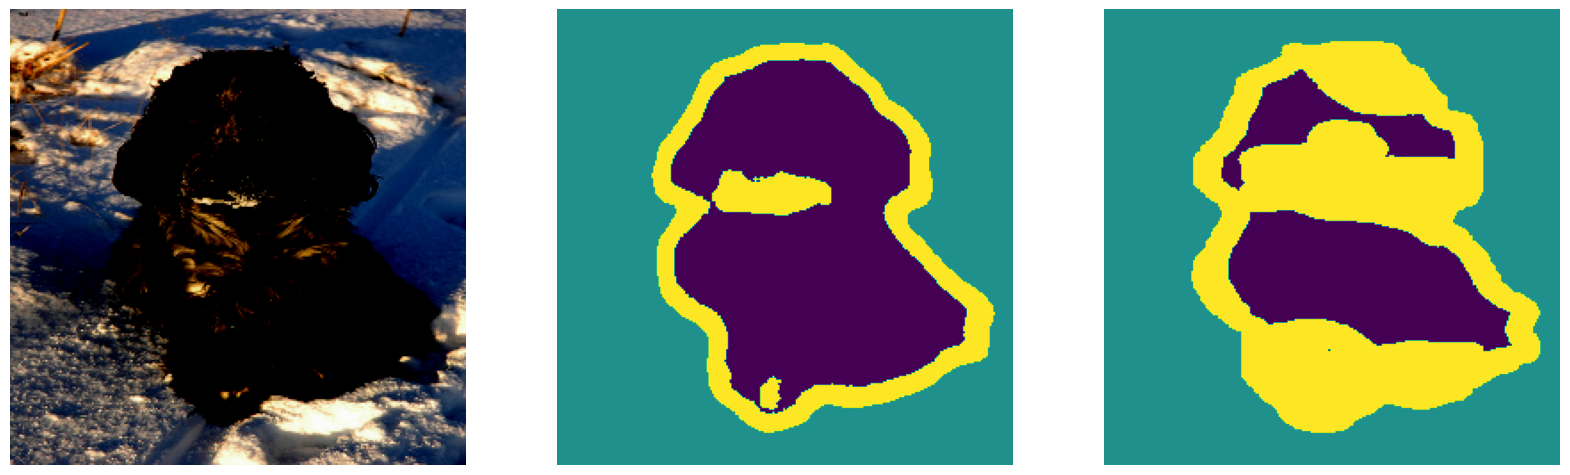

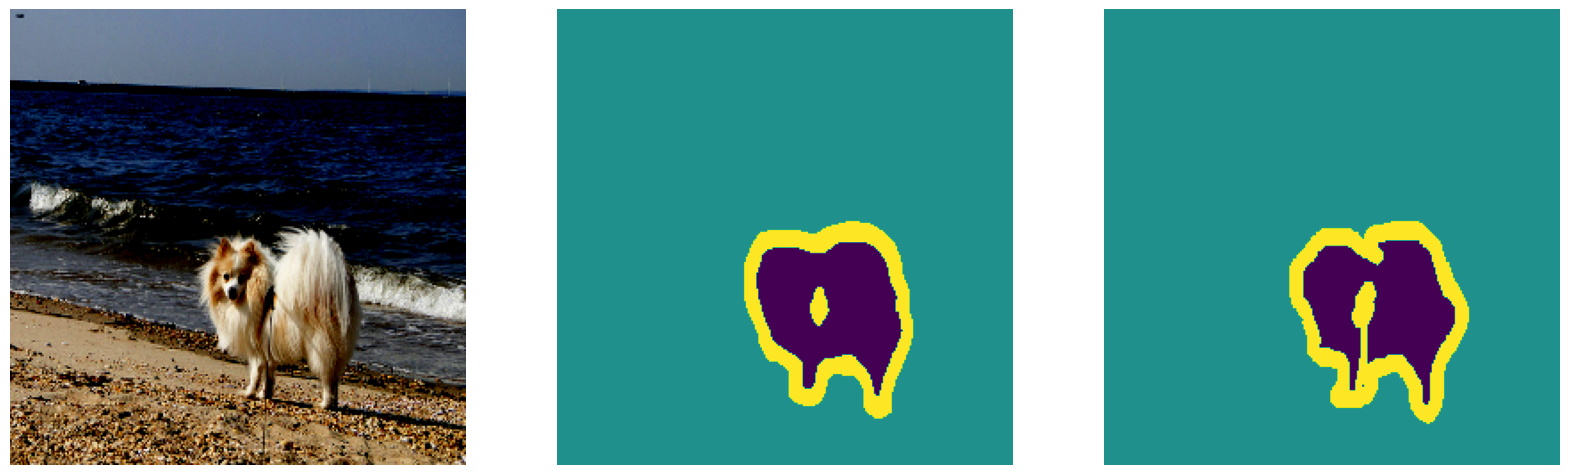

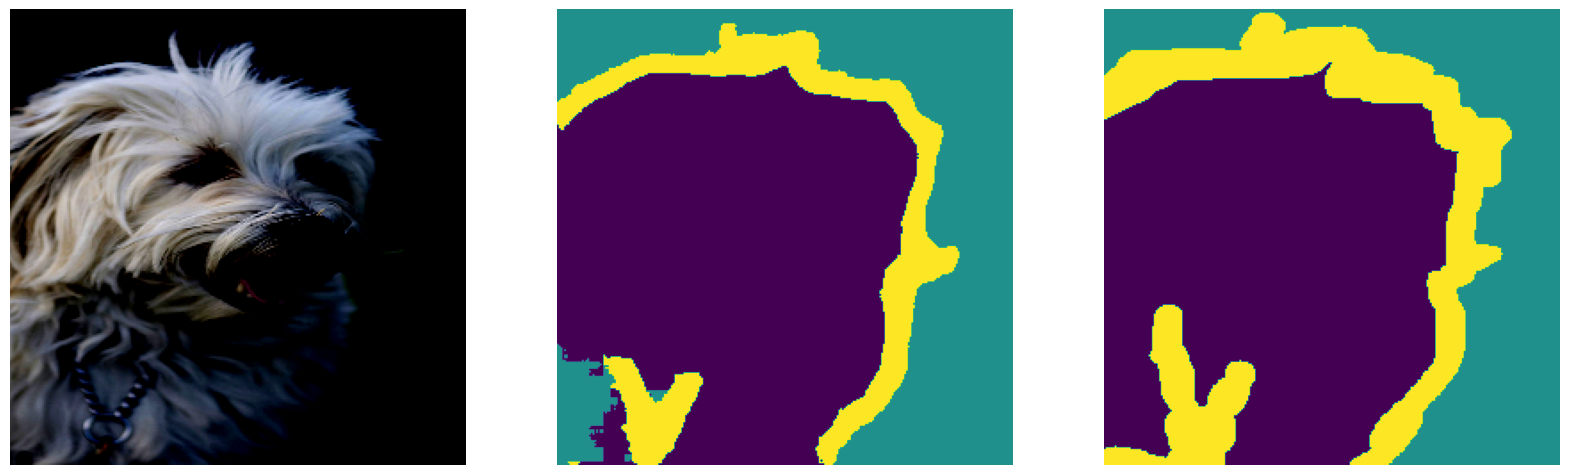

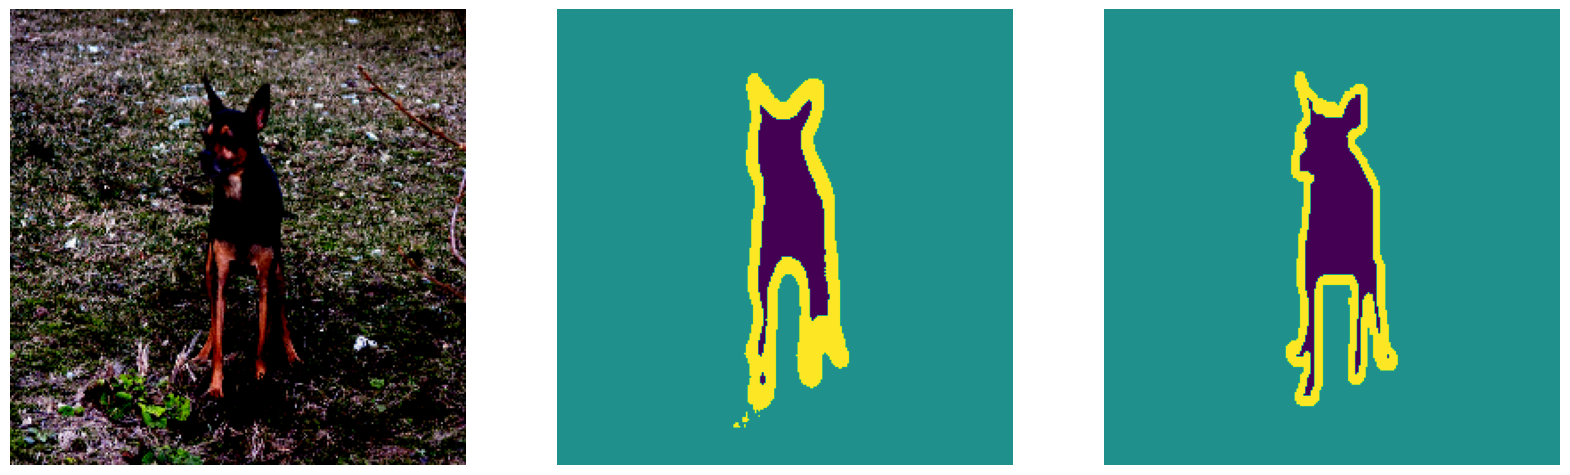

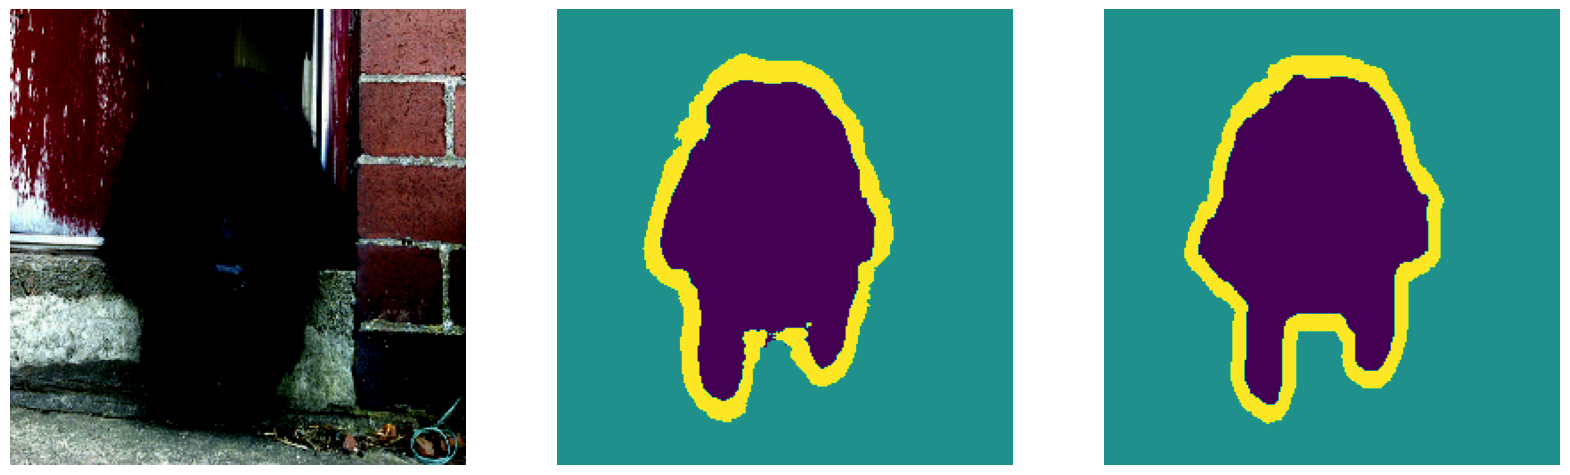

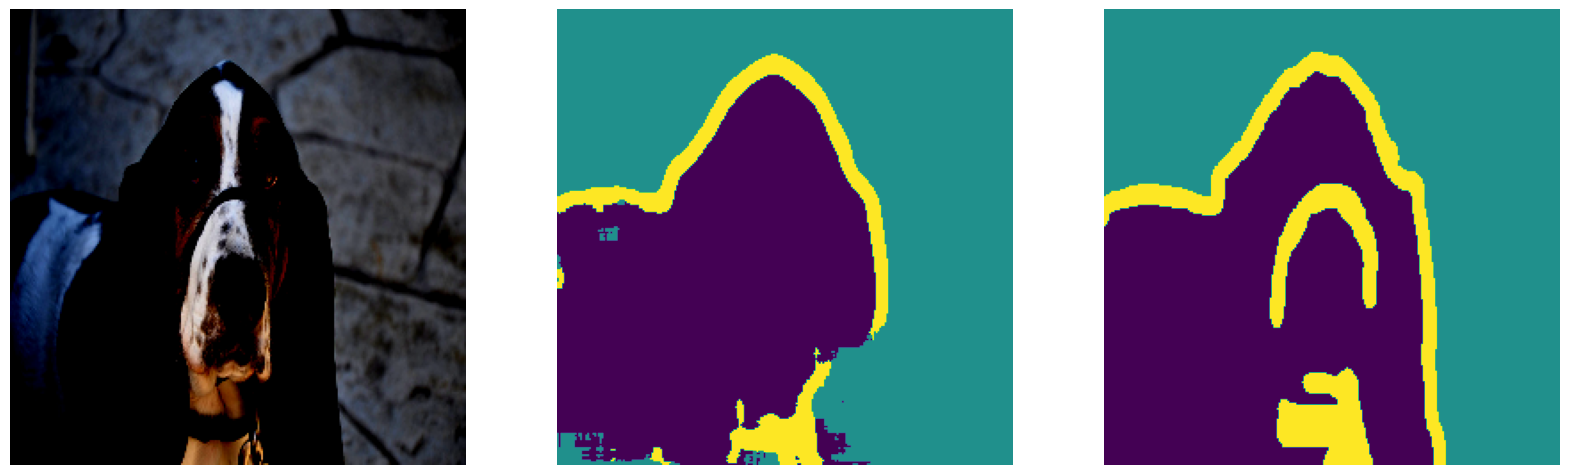

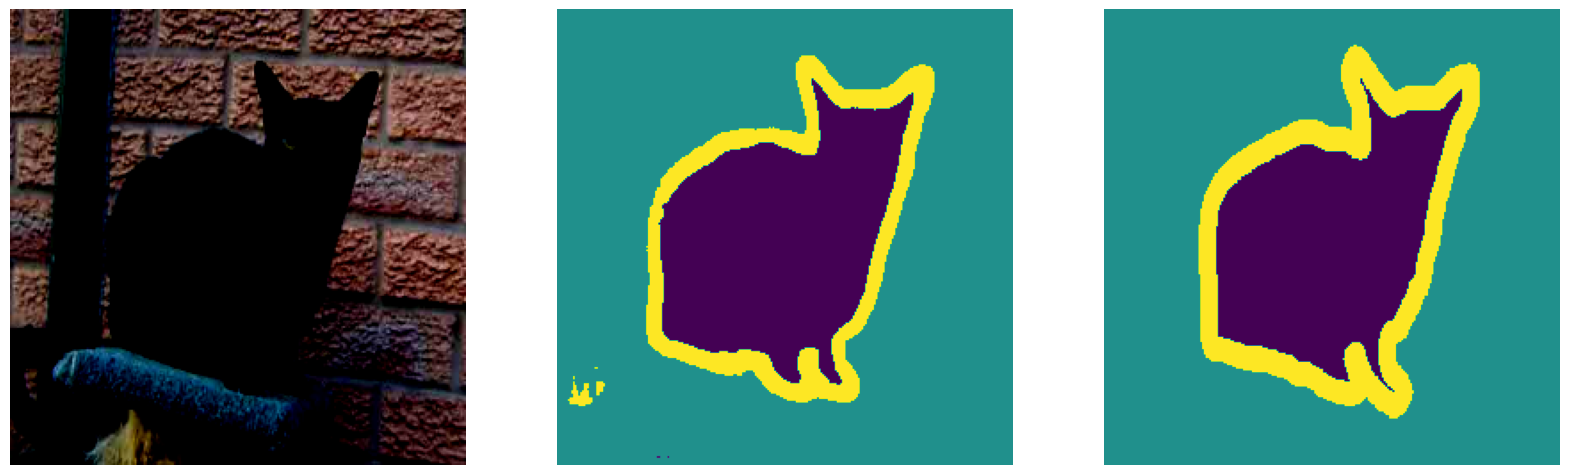

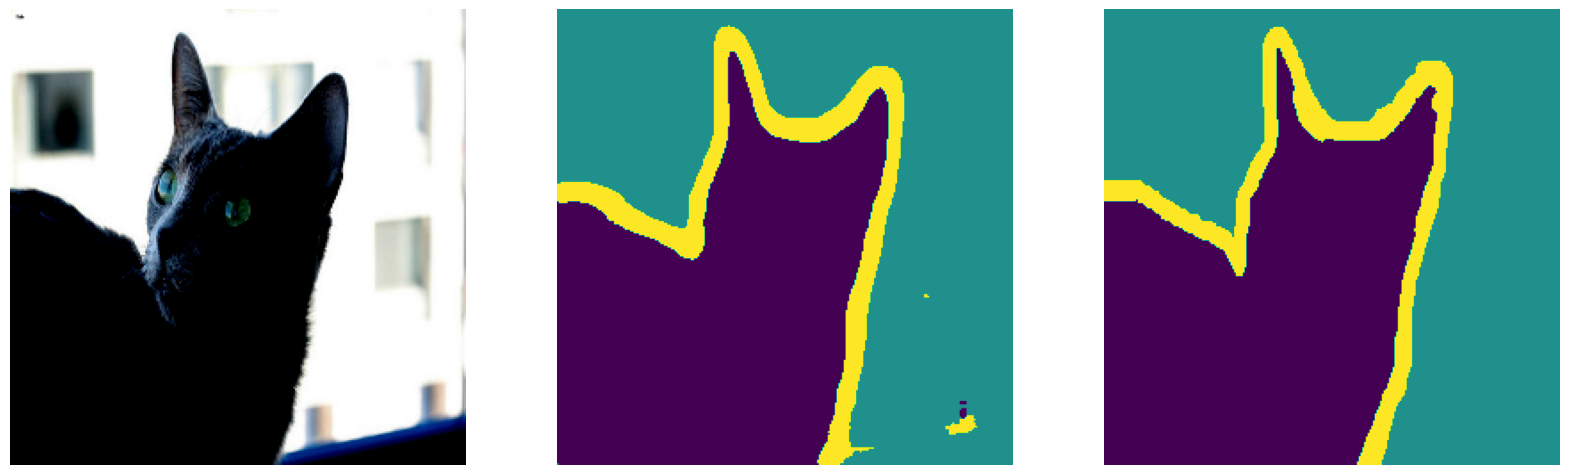

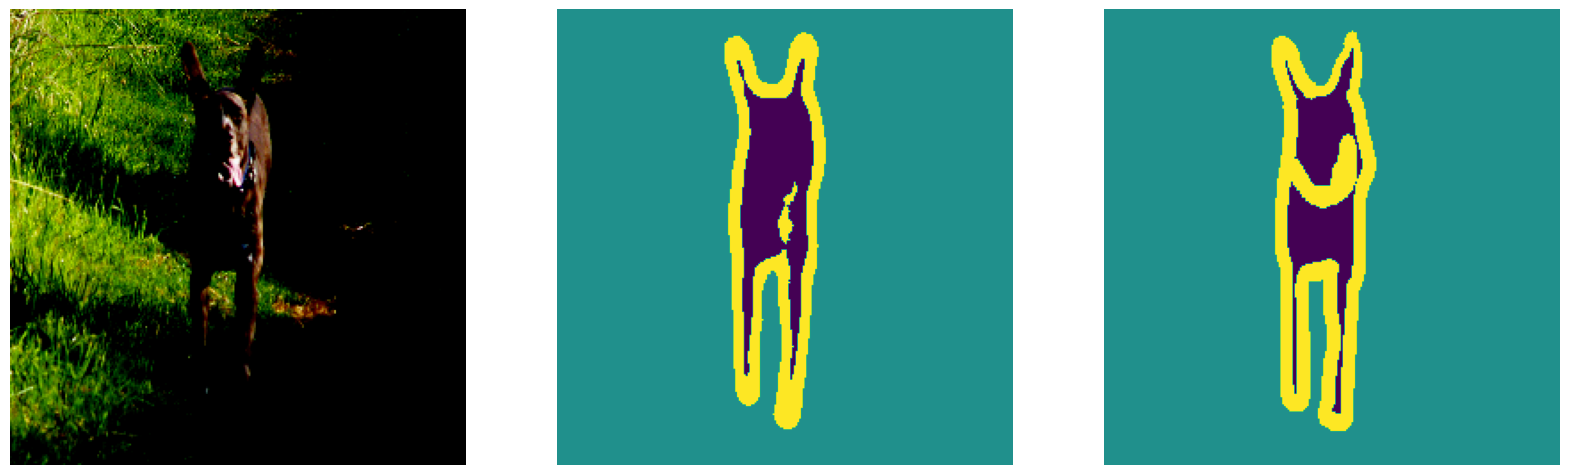

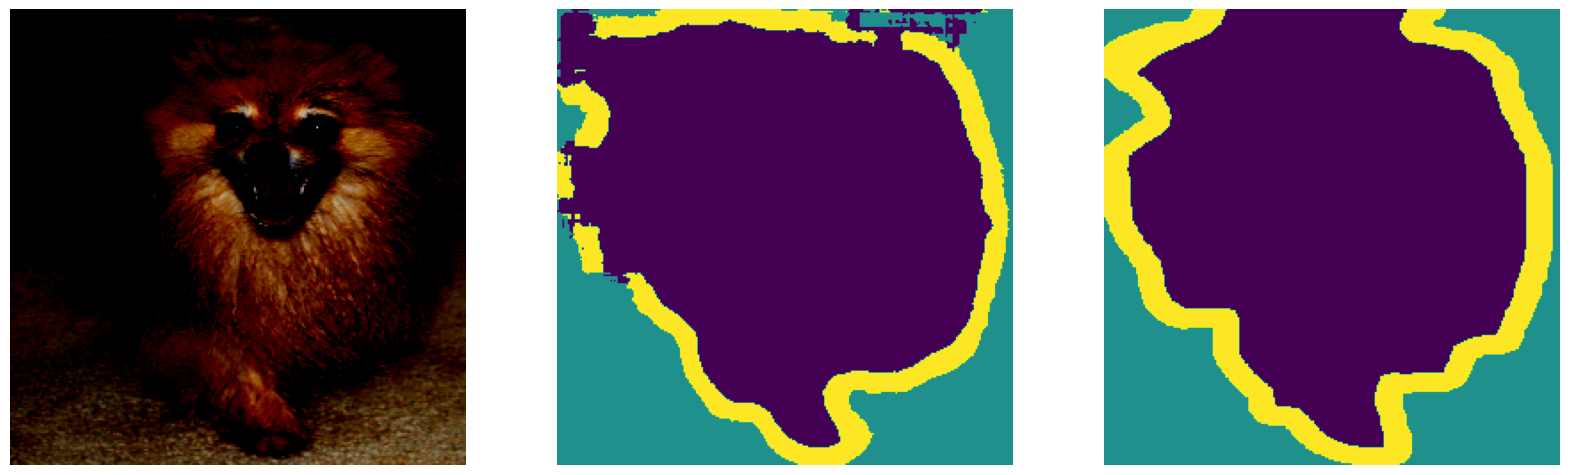

In [17]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_target = test_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_msk = test_target['semantic']
        
        _, gen_mask = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(test_msk, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')